In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, TargetEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.sparse import spmatrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import re
sys.path.append(os.path.abspath("../"))
from src.data.load_data import load_dataset
sys.path.append(os.path.abspath("../src")) 
from src.features.preprocess import deterministic_fe
from src.utils.helpers import other_titles,get_personal_title
from src.features.transformers import PersonalTitleTransformer
from src.features.pipe_config import preprocessing_pipeline
from src.utils.helpers import grid_search_res
from joblib import dump
%load_ext autoreload
%autoreload 2

In [ ]:
df = load_dataset('../data/raw/Titanic-dataset.csv')
idx2drop = df[df['Embarked'].isnull()].index
df = df.drop(idx2drop, axis=0)

### T/T split

X = df.drop('Survived',axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_save = X_train
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
# train.to_csv('../data/raw/train.csv')
# test.to_csv('../data/raw/test.csv')

In [ ]:
plt.figure(figsize = (8,6), dpi=150)
sns.countplot(data=df, x='Survived', hue='Survived')
plt.savefig('../reports/figures/09_class_imbalance.jpg')

In [ ]:
plt.figure(figsize=(18,6))
plt.subplots_adjust(wspace=0.4)

train = pd.concat([X_tr, y_train], axis=1)

for i,x in enumerate(['Pclass','SibSp', 'Parch', 'Fare', 'Age', 'Family_size']):
    plt.subplot(1,6,i+1)
    sns.histplot(train[x])
    group_mean = train.groupby(train[x])['Survived'].mean()
    ax = plt.gca()
    ax2=ax.twinx()
    sns.regplot(x=group_mean.index, y=list(group_mean),lowess=True,scatter=False, color='red')
    if i == 0:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel('')
    if i == 3:
        ax2.set_ylabel('\nAverage survival \nprobability (smoothed)')
    

In [114]:
# Default bayesianRidge()
categorical_transformer= ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False).set_output(transform = 'pandas'), ['Embarked', 'Personal_title']),
    ('target_enc', TargetEncoder(target_type='binary', random_state=42).set_output(transform = 'pandas'), ['Sex']),
    ('iterative_imputer', IterativeImputer(imputation_order='ascending',
                                        random_state = 42,
                                        min_value=1,
                                        max_value=80,
                                        tol = 0.00001),["Ticket_repeated",
                                                        "Family_size" ,
                                                        "Fare",
                                                        "Parch",
                                                        "SibSp",
                                                        "Pclass","Age"])
    
], remainder='passthrough', verbose_feature_names_out= False).set_output(transform="pandas")

scaling = ColumnTransformer([('normalization', PowerTransformer('yeo-johnson'), ['Fare', 'Pclass', 'SibSp', 'Parch', 'Age','Sex', 'Family_size'])
                       ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform="pandas")

categorical_preprocessor = Pipeline([
    ('Deterministic_fe', FunctionTransformer(deterministic_fe)), #drop ticket, idPassenger
    ('personal_title', PersonalTitleTransformer(treshold=40)),   #drop Name
    ('encode', categorical_transformer),
    ('scaling', scaling)
    ])

# SIMPLE LOGISTIC REGRESSION

### BASE MODEL

In [159]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = cross_validate(estimator=model,
                    scoring = scoring,
                    cv = skf,
                    X = X_train, y=y_train,
                    return_train_score=True)

### GRID SEARCH

ML FLOW DO ZAPISYWANIA PARAMETROW NA PRZYSZŁOŚĆ

NameError: name 'preproces_pipe' is not defined

In [180]:
results = pd.DataFrame(cv).mean().T

In [4]:
preprocess_pipe = preprocessing_pipeline()
model = Pipeline([
    ('preprocess', preprocess_pipe),
    ('log_model', LogisticRegression(max_iter=10000, solver='liblinear', random_state=42))
])

param_grid = {'log_model__C' : [0.8,0.9, 1, 1.1, 1.2],
              'log_model__penalty' : ['l1','l2'],
              }

In [5]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
}
gs = GridSearchCV(model, param_grid, scoring = scoring, cv=5, return_train_score=True, refit='f1')
gs.fit(X_train, y_train)

,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'log_model__C': [0.8, 0.9, ...], 'log_model__penalty': ['l1', 'l2']}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_weighted', 'precision': 'precision_weighted', 'recall': 'recall_weighted'}"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,steps,"[('Deterministic_fe', ...), ('personal_title', ...), ...]"


In [ ]:
gs.best_params_



{'log_model__C': 1.1, 'log_model__penalty': 'l1'}

In [9]:
#refitting
log_mod_pipe =Pipeline([
    ('Preprocess', preprocess_pipe),
    ('model',LogisticRegression(max_iter=10000, 
                             solver='liblinear',
                             random_state=42, 
                             C = 1.1,
                             penalty = 'l1') )
]) 
log_mod_pipe.fit(X_train, y_train)
preds = log_mod_pipe.predict(X_test)

In [ ]:
# dump(log_mod_pipe, '../src/dumped_models/log_reg_v1')

['../src/dumped_models/log_reg_v1']

In [10]:
best_model = gs.best_estimator_
preds = best_model.predict(X_test)
x = classification_report(y_test, preds, output_dict=True)
round(pd.DataFrame(x).T,3)


,precision,recall,f1-score,support
0,0.848,0.817,0.832,109.000
1,0.726,0.768,0.746,69.000
accuracy,0.798,0.798,0.798,0.798
macro avg,0.787,0.792,0.789,178.000
weighted avg,0.800,0.798,0.799,178.000


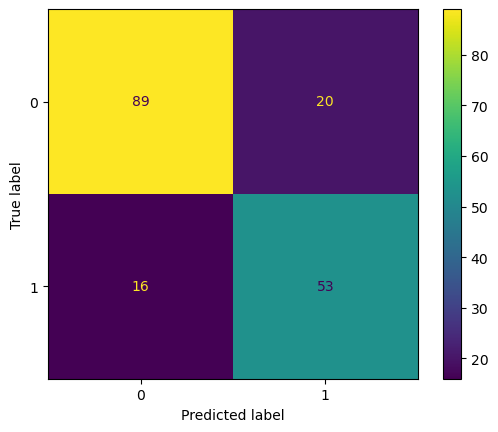

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, preds)

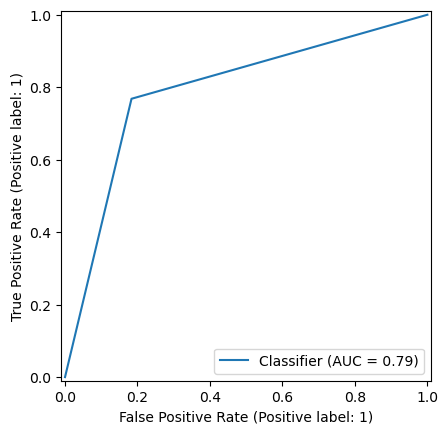

In [13]:
RocCurveDisplay.from_predictions(y_test, preds)

In [15]:
np.std(X_train['Fare'])

np.float64(49.16061939015334)

In [14]:
best_pipe = gs.best_estimator_
preprocess_pipe = best_pipe.named_steps['preprocess']
col_names = preprocess_pipe.transform(X_train).columns
coefs = np.exp(best_pipe.named_steps['log_model'].coef_)
pd.DataFrame(coefs, columns = col_names).T


,0
Fare,1.193959
Pclass,0.384578
SibSp,0.770372
Parch,0.833709
Age,0.580120
Sex,2.133253
Family_size,0.828973
Embarked_Q,1.000000
Embarked_S,0.557539
Personal_title_Mr,0.392858


### DATA IS PREPROCESSED

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), dpi = 150, nrows= 2, ncols= 1)
sns.histplot(data=X, x = 'Age', color='red', ax=ax[0])
sns.histplot(data=X_train,x = 'Age', color='blue', ax=ax[1])
ax[0].set_title('Train set before imputation')
ax[1].set_title('Train set after imputation')
plt.tight_layout()
# plt.savefig('../reports/figures/07_imputation_comparison.jpg')

In [ ]:
idx = X_train_save.loc[X_train_save['Age'].isnull(), 'Age'].index

X_train_age_imputed = X_train.loc[idx]

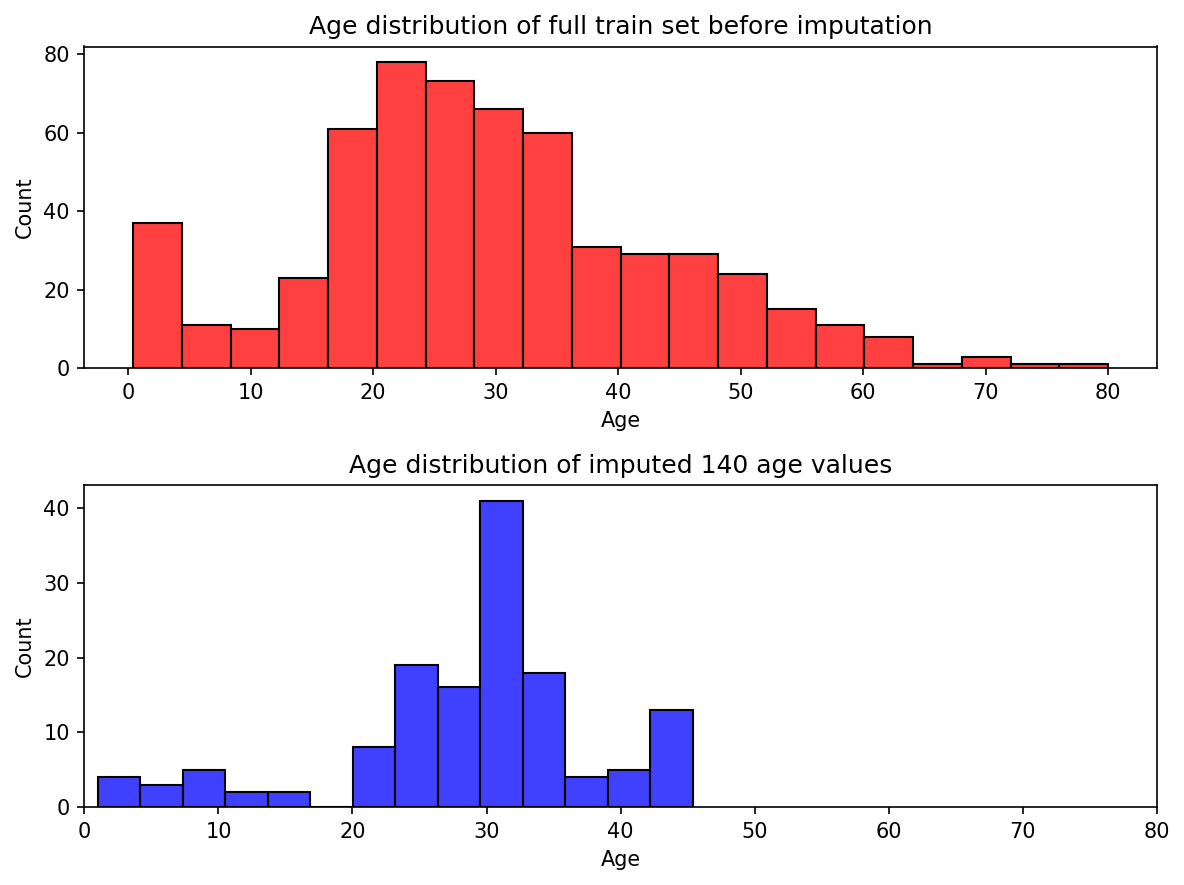

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize =(8,6), dpi = 150)
sns.histplot(data=X_train_save, x='Age', color = 'red', ax=ax[0])
sns.histplot(data=X_train_age_imputed, x='Age', color = 'blue', ax=ax[1])

ax[0].set_title('Age distribution of full train set before imputation')

ax[1].set_title('Age distribution of imputed 140 age values')
ax[1].set_xlim(0,80)
plt.tight_layout()
plt.savefig('../reports/figures/08_age_distribution_of_imputation.jpg')

In [ ]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Ticket_repeated,Family_size,Sex_coded,Embarked_C,Embarked_Q,Embarked_nan,Personal_title_Miss,Personal_title_Other,Personal_title_Mrs
0,1.0,45.500000,0.0,0.0,28.5000,0.0,0.0,0.185317,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,23.000000,0.0,0.0,13.0000,0.0,0.0,0.193355,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,32.000000,0.0,0.0,7.9250,0.0,0.0,0.177751,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,26.000000,1.0,0.0,7.8542,0.0,1.0,0.184326,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,6.000000,4.0,2.0,31.2750,1.0,6.0,0.749759,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3.0,21.000000,0.0,0.0,7.6500,0.0,0.0,0.722984,0.0,0.0,0.0,1.0,0.0,0.0
708,1.0,43.902012,0.0,0.0,31.0000,0.0,0.0,0.185317,0.0,0.0,0.0,0.0,0.0,0.0
709,3.0,41.000000,2.0,0.0,14.1083,0.0,2.0,0.184326,0.0,0.0,0.0,0.0,0.0,0.0
710,1.0,14.000000,1.0,2.0,120.0000,1.0,3.0,0.739614,0.0,0.0,0.0,1.0,0.0,0.0


### TEST

In [18]:
from src.models.train import train_log_model
from src.models.test import create_report, test_log_model

In [13]:
best_model = train_log_model()

In [15]:
out = test_model(best_model,'log_reg',on_version = 'v1')

In [15]:
test_log_model(best_model)

NameError: name 'test_log_model' is not defined

In [ ]:
out = test_model(best_model,'log_reg',on_version = 'v1')

# Raportowanie działa, pytanie pozsostaje dlaczego w zasadzie wogule uzywam grid searcha tam. To temat do zbadania napewno + na przyszłość obsługa wyjątków w raporcie excel i przelecenie przez reszte modeli
# Deadline raczej taki zeby w tym tygodniu skończyć

In [24]:
from joblib import load
load('../src/dumped_models/best_model_logreg_v1.pkl')

,steps,"[('preprocess', ...), ('log_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('Deterministic_fe', ...), ('personal_title', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function det...t 0x302d2db20>
,inverse_func,None
,validate,False
